In [1]:
%pip install scipy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial

Given two lattices, ${\Lambda(G)}$ and $\Lambda(\alpha G)$, for some $\alpha \in \mathbb{Z}$ and a nearest-neighbor quantizer $Q^{(NN)}_{\Lambda}$, Design an algorithm (both encoder and decoder) that, given any $x \in \mathbb{R}^n$, returns the coset of $\Lambda(\alpha G)$, which is a point in $\Lambda(G)$. Use ideas from nested lattices chapter.

Let's first get intusion from the following example. $\Lambda _1$ is $A_2$ (Hexagonal lattice) and $\Lambda _2$ is $3 \cdot A_2$. 

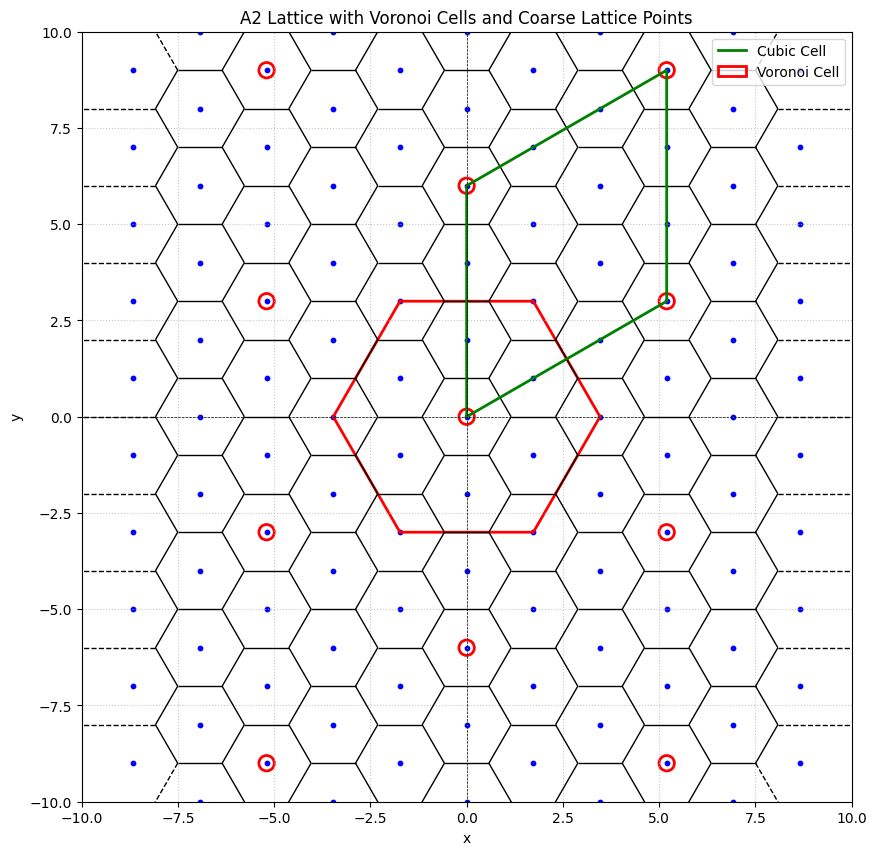

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

def plot_lattice_with_voronoi_and_cubic_cell(basis, q=3, scale=1, xlim=(-10, 10), ylim=(-10, 10)):
    x_range = np.arange(xlim[0], xlim[1] + 1)
    y_range = np.arange(ylim[0], ylim[1] + 1)
    points = []
    coarse_points = []
    
    for i in x_range:
        for j in y_range:
            point = np.dot(np.array([i, j]), scale * basis)
            if xlim[0] <= point[0] <= xlim[1] and ylim[0] <= point[1] <= ylim[1]:
                points.append(point)
                # Identifying the coarse lattice points
                if i % q == 0 and j % q == 0:
                    coarse_points.append(point)
    
    points = np.array(points)
    coarse_points = np.array(coarse_points)
    vor = Voronoi(points)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)
    ax.scatter(points[:, 0], points[:, 1], s=10, color='blue')
    
    for point in coarse_points:
        circle = plt.Circle((point[0], point[1]), 0.2, fill=False, color='red', linewidth=2)
        ax.add_artist(circle)
    
    # Plotting the fundamental cubic cell of the coarse lattice
    coarse_basis = basis * q  # Scale the basis by 'q' for the coarse lattice
    vertices = np.array([
        [0, 0], 
        coarse_basis[0], 
        coarse_basis[0] + coarse_basis[1], 
        coarse_basis[1]
    ])
    
    # Close the loop by connecting the last vertex to the origin
    ax.plot(*zip(*np.vstack([vertices, vertices[0]])), 'g-', linewidth=2, label='Cubic Cell')
    
    origin_index = np.where((points == [0, 0]).all(axis=1))[0][0]
    region = vor.regions[vor.point_region[origin_index]]
    
    # Plot the Voronoi cell around the origin
    if -1 not in region:
        polygon = [vor.vertices[i] for i in region]
        scaled_polygon = [[q * x, q * y] for x, y in polygon]  # Scale for the coarse lattice
        ax.fill(*zip(*scaled_polygon), fill=False, edgecolor='r', linewidth=2, label='Voronoi Cell')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_title("A2 Lattice with Voronoi Cells and Coarse Lattice Points")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    plt.show()

# Use the A2 basis
A2_basis = np.array([[0, 2], [np.sqrt(3), 1]])
plot_lattice_with_voronoi_and_cubic_cell(A2_basis, q=3)
plt.show()

In this setting, we wish to represent the amount of fine lattice points in the Voronoi cell of the coarse lattice using bits.

To encode them all we need $ciel(log_2(det(3 * I)))$ bits, which is 4. 

Lookup map = {
    (0, 0): 0000,
    (0, 2): 0001,
    (0, -2): 0010,
    (sqrt(3), -1): 0011,
    (sqrt(3), 1): 0100,
    (-sqrt(3), -1): 0101,
    (-sqrt(3), 1): 0110,
    (2sqrt(3)), 0): 0111,
    (sqrt(3), -3): 1000
    }

Also let's assume we have a reverse lookup map that maps a bitstring to a coset the fine lattice.

Encoder algorithm:

func encoder(x): # $x$ is in $\mathbb{R}^2$
1. x' = $Q^{NN}_{A_2}(x)$. # projection of x onto the nearest neighbor of A_2
2. x'' = $Q^{NN}_{3A_2}(x)$. # projection of x onto the nearest neighbor of 3 * A_2
3. x_e = x'' - x'
4. return lookup_map[- x_e] # lookup_map is a map from the cosets of the fine lattice to bits.

Decoder algorithm:

func decoder(y): # $y$ is bitstring.
1. return reverse_lookup_map[y]

Lets visualize the algorithm. presented above, if our $ x = (3.5, 4.5)$.

$Q^{NN}_{A_2}(x) = (2sqrt(3), 4)$,

$Q^{NN}_{3A_2}(x) = (3sqrt(3), 3)$,

$- x_e = (3sqrt(3), 3) - (2sqrt(3), 4) = (sqrt(3), -1)$


x = [3.5 4.5]
x' = [3.46410162 4.        ]
x'' = [5.19615242 3.        ]
x_e = [ 1.73205081 -1.        ]


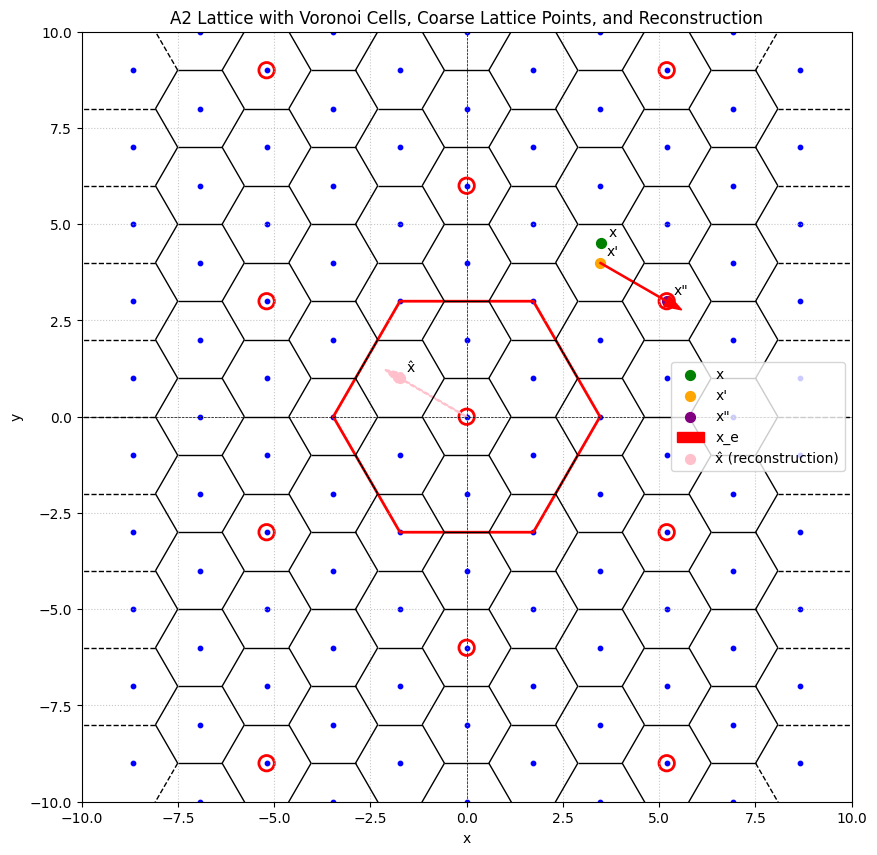

In [4]:
from scipy.spatial import Voronoi, voronoi_plot_2d

x = np.array([3.5, 4.5])

# Define the A2 lattice basis
A2_basis = np.array([[0, 2], [np.sqrt(3), 1]])

# Define the function to find the nearest lattice point
def nearest_lattice_point(point, basis):
    inv_basis = np.linalg.inv(basis)
    rounded = np.round(np.dot(point, inv_basis))
    return np.dot(rounded, basis)

x_prime = nearest_lattice_point(x, A2_basis)

x_double_prime = nearest_lattice_point(x, 3 * A2_basis)

# Calculate x_e
x_e = x_double_prime - x_prime

# Print the results
print(f"x = {x}")
print(f"x' = {x_prime}")
print(f"x'' = {x_double_prime}")
print(f"x_e = {x_e}")

def plot_lattice_with_voronoi(basis, scale=1, xlim=(-10, 10), ylim=(-10, 10)):
    x_range = np.arange(xlim[0], xlim[1] + 1)
    y_range = np.arange(ylim[0], ylim[1] + 1)
    points = []
    coarse_points = []
    
    for i in x_range:
        for j in y_range:
            point = np.dot(np.array([i, j]), scale * basis)
            if xlim[0] <= point[0] <= xlim[1] and ylim[0] <= point[1] <= ylim[1]:
                points.append(point)
                if i % 3 == 0 and j % 3 == 0:
                    coarse_points.append(point)
    
    points = np.array(points)
    coarse_points = np.array(coarse_points)
    vor = Voronoi(points)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)
    ax.scatter(points[:, 0], points[:, 1], s=10, color='blue')
    
    for point in coarse_points:
        circle = plt.Circle((point[0], point[1]), 0.2, fill=False, color='red', linewidth=2)
        ax.add_artist(circle)

    origin_index = np.where((points == [0, 0]).all(axis=1))[0][0]

    region = vor.regions[vor.point_region[origin_index]]

    if -1 not in region:
        polygon = [vor.vertices[i] for i in region]
        scaled_polygon = [[3*x, 3*y] for x, y in polygon]
        ax.fill(*zip(*scaled_polygon), fill=False, edgecolor='r', linewidth=2)
    
    ax.scatter(x[0], x[1], color='green', s=50, label='x')
    ax.scatter(x_prime[0], x_prime[1], color='orange', s=50, label="x'")
    ax.scatter(x_double_prime[0], x_double_prime[1], color='purple', s=50, label='x"')
    ax.arrow(x_prime[0], x_prime[1], x_e[0], x_e[1], color='red', width=0.03, head_width=0.3, label='x_e')

    x_hat = np.array([0, 0]) - x_e 
    
    ax.scatter(x_hat[0], x_hat[1], color='pink', s=50, label='x̂ (reconstruction)')
    
    ax.arrow(0, 0, x_hat[0], x_hat[1], color='pink', width=0.03, head_width=0.3, linestyle='--')
    
    ax.annotate('x', (x[0], x[1]), xytext=(5, 5), textcoords='offset points')
    ax.annotate("x'", (x_prime[0], x_prime[1]), xytext=(5, 5), textcoords='offset points')
    ax.annotate('x"', (x_double_prime[0], x_double_prime[1]), xytext=(5, 5), textcoords='offset points')
    ax.annotate('x̂', (x_hat[0], x_hat[1]), xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_title("A2 Lattice with Voronoi Cells, Coarse Lattice Points, and Reconstruction")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    plt.show()

# Plot A2 lattice
plot_lattice_with_voronoi(A2_basis)


Lets think of the following improvements.

1. Implement $Q_{3 A_2}^{NN}(x)$ using $Q_{A_2}^{NN}(x)$.

we can use the following property of nearest neighbors:
$Q_{3 A_2}^{NN}(x) = 3 Q_{A_2}^{NN}(x/3)$

2. Implement step 4 of the encoder and step 1 of the decoder using only multiplication by $G$, multiplication by $G^{-1}$, application of $Q_{\Lambda}^{NN}$ and reduction modulo 3. 

x = [3.5 4.5]
x' = [3.46410162 4.        ]
x'' = [5.19615242 3.        ]
x_e = [ 1.73205081 -1.        ]


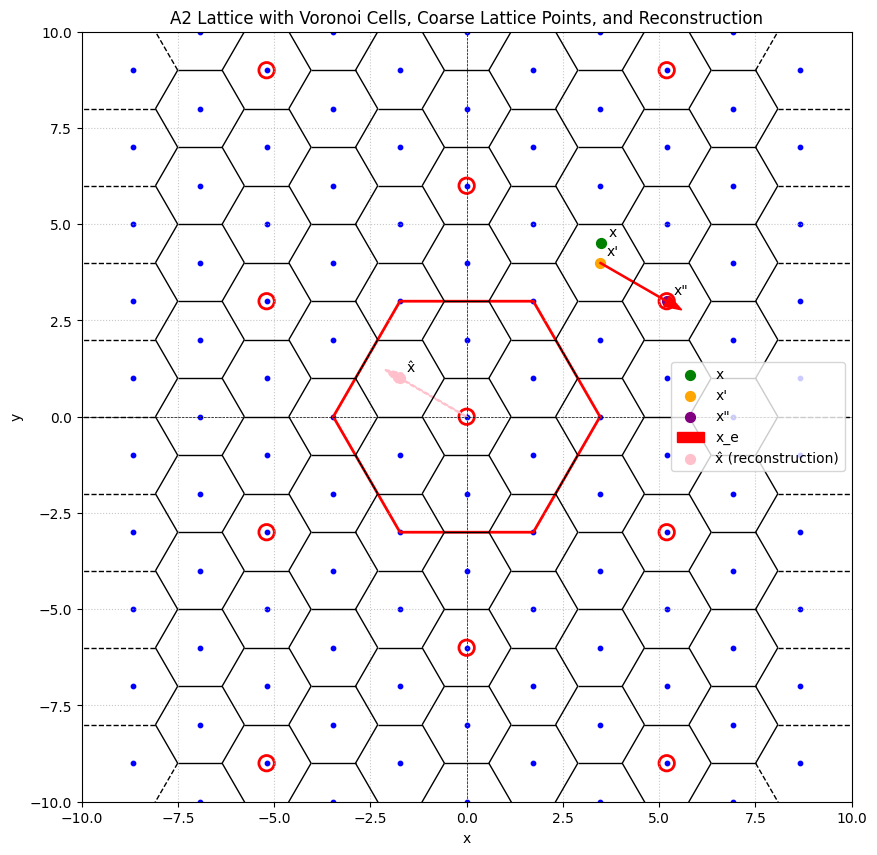

In [5]:
from scipy.spatial import Voronoi, voronoi_plot_2d

x = np.array([3.5, 4.5])

# Define the A2 lattice basis
A2_basis = np.array([[0, 2], [np.sqrt(3), 1]])

# Define the function to find the nearest lattice point
def nearest_lattice_point(point, basis):
    inv_basis = np.linalg.inv(basis)
    rounded = np.round(np.dot(point, inv_basis))
    return np.dot(rounded, basis)

x_prime = nearest_lattice_point(x, A2_basis)

# Modified function to find the nearest point in the coarse lattice
def nearest_coarse_lattice_point(point, basis):
    scaled_point = point / 3
    nn_quantized = nearest_lattice_point(scaled_point, basis)
    return 3 * nn_quantized

x_double_prime = nearest_coarse_lattice_point(x, A2_basis)

# Calculate x_e
x_e = x_double_prime - x_prime

# Print the results
print(f"x = {x}")
print(f"x' = {x_prime}")
print(f"x'' = {x_double_prime}")
print(f"x_e = {x_e}")

def plot_lattice_with_voronoi(basis, scale=1, xlim=(-10, 10), ylim=(-10, 10)):
    x_range = np.arange(xlim[0], xlim[1] + 1)
    y_range = np.arange(ylim[0], ylim[1] + 1)
    points = []
    coarse_points = []
    
    for i in x_range:
        for j in y_range:
            point = np.dot(np.array([i, j]), scale * basis)
            if xlim[0] <= point[0] <= xlim[1] and ylim[0] <= point[1] <= ylim[1]:
                points.append(point)
                if i % 3 == 0 and j % 3 == 0:
                    coarse_points.append(point)
    
    points = np.array(points)
    coarse_points = np.array(coarse_points)
    vor = Voronoi(points)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)
    ax.scatter(points[:, 0], points[:, 1], s=10, color='blue')
    
    for point in coarse_points:
        circle = plt.Circle((point[0], point[1]), 0.2, fill=False, color='red', linewidth=2)
        ax.add_artist(circle)

    origin_index = np.where((points == [0, 0]).all(axis=1))[0][0]

    region = vor.regions[vor.point_region[origin_index]]

    if -1 not in region:
        polygon = [vor.vertices[i] for i in region]
        scaled_polygon = [[3*x, 3*y] for x, y in polygon]
        ax.fill(*zip(*scaled_polygon), fill=False, edgecolor='r', linewidth=2)
    
    ax.scatter(x[0], x[1], color='green', s=50, label='x')
    ax.scatter(x_prime[0], x_prime[1], color='orange', s=50, label="x'")
    ax.scatter(x_double_prime[0], x_double_prime[1], color='purple', s=50, label='x"')
    ax.arrow(x_prime[0], x_prime[1], x_e[0], x_e[1], color='red', width=0.03, head_width=0.3, label='x_e')

    x_hat = np.array([0, 0]) - x_e 
    
    ax.scatter(x_hat[0], x_hat[1], color='pink', s=50, label='x̂ (reconstruction)')
    
    ax.arrow(0, 0, x_hat[0], x_hat[1], color='pink', width=0.03, head_width=0.3, linestyle='--')
    
    ax.annotate('x', (x[0], x[1]), xytext=(5, 5), textcoords='offset points')
    ax.annotate("x'", (x_prime[0], x_prime[1]), xytext=(5, 5), textcoords='offset points')
    ax.annotate('x"', (x_double_prime[0], x_double_prime[1]), xytext=(5, 5), textcoords='offset points')
    ax.annotate('x̂', (x_hat[0], x_hat[1]), xytext=(5, 5), textcoords='offset points')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_title("A2 Lattice with Voronoi Cells, Coarse Lattice Points, and Reconstruction")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    plt.show()

# Plot A2 lattice
plot_lattice_with_voronoi(A2_basis)


please write check to test this step
The encoded vector F_3^2 = {0, 1, 2}^2  represents the coefficients of the “amount” we take from each base vector. Therefore, step 4 is:
(x_e^T \cdot G^{-1}) \mod 3

And step 1 in the decoder is: G \cdot y

In [6]:

def nearest_lattice_point(point, basis):
    inv_basis = np.linalg.inv(basis)
    rounded = np.round(np.dot(point, inv_basis))
    return np.dot(rounded, basis)

def nearest_lattice_point(point, basis):
    inv_basis = np.linalg.inv(basis)
    coefficients = np.round(np.dot(point, inv_basis))
    return coefficients.astype(int)  # Return integer coefficients

# Test the updated function
b1, b2 = np.array([np.sqrt(3), 1]), np.array([0, 2])
G = np.array([b1, b2])

test_point = np.array([0, 2.2])
result = nearest_lattice_point(test_point, G)
print(f"Coefficients for {test_point}: {result}")

# Expected output: [1, 0]
assert np.array_equal(result, np.array([0, 1])), "Test failed: unexpected coefficients"
print("Test passed: function returns correct coefficients")

# now tests the decoder

def decoder(y):
    return np.dot(y, G)

test_y = np.array([0, 1])
result = decoder(test_y)
print(f"Decoded vector for {test_y}: {result}")


Coefficients for [0.  2.2]: [0 1]
Test passed: function returns correct coefficients
Decoded vector for [0 1]: [0. 2.]
